# Magma Keras to TensorRT

### Importing

In [18]:
import keras
from keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile

import time 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import os
from os.path import exists, isdir, join

import shutil

### For Jetson TX2

In [19]:
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [20]:
CNN_MODEL = 'MagmaCnnClassifier.hdf5'
TARGET_SHAPE = 8
DATA_SHAPE = (100,100,3)
BATCH_SIZE = 256

SAVED_MODEL_DIR = './saved_model/'
MODEL_NAME = CNN_MODEL

DATA_SHAPE = (100,100,3)
TRAIN_DIR = "./data/train"
TEST_DIR = "./data/test"
RESULT_PREDICTION_CALLBACK = None

sub_dir = time.strftime("%Y_%m_%d-%H_%M_%S", time.localtime())

# Data preprocessing
### create predict_dir by move random pictures from test_dir  
#### remove and copy test_dir

In [21]:
TEST_COPY_DIR = './data/test_dir'
PREDICT_DIR = './data/predict_dir'

In [22]:
# delete folder if exist
if exists(TEST_COPY_DIR) and isdir(TEST_COPY_DIR):
    shutil.rmtree(TEST_COPY_DIR)
print('remove if exist test_dir success')

if exists(PREDICT_DIR) and isdir(PREDICT_DIR):
    shutil.rmtree(PREDICT_DIR)
print('remove if exist predict_dir success')

#copy test as test_dir, there are result as list of copy files
# from distutils.dir_util import copy_tree
# copy_tree('./data/test','./data/test_dir')
from subprocess import call
call(['cp','-a', TEST_DIR, TEST_COPY_DIR])
print('copy test to test_dir success')

remove if exist test_dir success
remove if exist predict_dir success
copy test to test_dir success


#### create predict_dir and random moving images

In [23]:
#random select images
CATEGORIES = ['0','1','2','3','4','5','6','7']
IMAGES_PER_FOLDER = 4

In [24]:
import random
for category in CATEGORIES:
    
    path_ct = join(TEST_COPY_DIR,category)
    path_pd = join(PREDICT_DIR, category)
    
    if not exists(path_pd):
        os.makedirs(path_pd)
    
    image_list = os.listdir(path_ct)
    random.shuffle(image_list)
    
    for img in image_list[:IMAGES_PER_FOLDER]:
        path_src = join(path_ct,img)
        path_des = join(path_pd,img)
        shutil.move(path_src, path_des)
    
    print('copy - category:',category, image_list[:IMAGES_PER_FOLDER])
    
    

copy - category: 0 ['2987.png', '1727.png', '43.png', '3805.png']
copy - category: 1 ['9037.png', '1742.png', '628.png', '6834.png']
copy - category: 2 ['4414.png', '9463.png', '342.png', '4415.png']
copy - category: 3 ['178.png', '209.png', '10034.png', '7822.png']
copy - category: 4 ['7026.png', '442.png', '4967.png', '2403.png']
copy - category: 5 ['9362.png', '7568.png', '3913.png', '4987.png']
copy - category: 6 ['7665.png', '7594.png', '4766.png', '10168.png']
copy - category: 7 ['2849.png', '2122.png', '7687.png', '4856.png']


# WorkFlow

### Keras to TensorRT
![alt text](pictures/Keras_to_TensorRT.png)

## d) Inference using TensorRT model

#### d.1) Function to read ".pb" model (TensorRT model is stored in ".pb")

In [25]:
# (can be used to read frozen model or TensorRT model)
def read_pb_graph(model):
    with gfile.FastGFile(model,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

#### d.2) prepare data for prediction

In [26]:
images = []
for category in CATEGORIES:
    path_pd = join(PREDICT_DIR, category)
    class_num = CATEGORIES.index(category)
    image_list = os.listdir(path_pd)
    
    for img in image_list:
        images.append([join(path_pd,img),class_num,img])

print("Total images: ",len(images))
print(*images, sep='\n')

Total images:  32
['./data/predict_dir/0/1727.png', 0, '1727.png']
['./data/predict_dir/0/3805.png', 0, '3805.png']
['./data/predict_dir/0/2987.png', 0, '2987.png']
['./data/predict_dir/0/43.png', 0, '43.png']
['./data/predict_dir/1/628.png', 1, '628.png']
['./data/predict_dir/1/6834.png', 1, '6834.png']
['./data/predict_dir/1/9037.png', 1, '9037.png']
['./data/predict_dir/1/1742.png', 1, '1742.png']
['./data/predict_dir/2/4415.png', 2, '4415.png']
['./data/predict_dir/2/342.png', 2, '342.png']
['./data/predict_dir/2/9463.png', 2, '9463.png']
['./data/predict_dir/2/4414.png', 2, '4414.png']
['./data/predict_dir/3/10034.png', 3, '10034.png']
['./data/predict_dir/3/209.png', 3, '209.png']
['./data/predict_dir/3/7822.png', 3, '7822.png']
['./data/predict_dir/3/178.png', 3, '178.png']
['./data/predict_dir/4/442.png', 4, '442.png']
['./data/predict_dir/4/7026.png', 4, '7026.png']
['./data/predict_dir/4/4967.png', 4, '4967.png']
['./data/predict_dir/4/2403.png', 4, '2403.png']
['./data/predi

In [27]:
input_img = []

for image in images:
    img = load_img(path=image[0], color_mode='rgb', target_size=DATA_SHAPE)
    img2predict = img.copy()
    img2predict = img_to_array(img2predict)
    img2predict /= 255
    input_img.append(img2predict)
#     break # <<-- use only 1 image
    
input_img = np.array(input_img)
print(input_img.shape)

(32, 100, 100, 3)


#### d.3) Function for calculating acuuracy

In [28]:
def calculate_acc(images, predictions):
    count = 0
    for i in range(len(images)):
        # images[i][1] is real value
        print(i," real_val:", images[i][1], "pred_val:",np.argmax(predictions[i]))
        if images[i][1] == np.argmax(predictions[i]):
              count += 1
              
    return count / len(images) * 100

## Inference using TensorRT model

In [40]:
TENSORRT_MODEL_PATH = './saved_model/TensorRT_Magma_model-2019_07_08-15_30_13.pb'

graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:
        # read TensorRT model
        print('Read TensorRT model')
        trt_graph = read_pb_graph(TENSORRT_MODEL_PATH)
        [print(idx, node.name) for idx , node in enumerate(trt_graph.node)]

Read TensorRT model
0 PermConstNCHWToNHWC-LayoutOptimizer
1 flatten_1/stack/0
2 input_tensor_input
3 PermConstNHWCToNCHW-LayoutOptimizer
4 flatten_1/strided_slice/stack
5 flatten_1/strided_slice/stack_1
6 keras_learning_phase/input
7 input_tensor/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer
8 keras_learning_phase
9 dropout_1/cond/Switch
10 dropout_1/cond/switch_t
11 dropout_1/cond/dropout/keep_prob
12 max_pooling2d_4/MaxPool-1-0-TransposeNCHWToNHWC-LayoutOptimizer
13 flatten_1/Shape
14 flatten_1/Shape-0-0-VecPermuteNCHWToNHWC-LayoutOptimizer
15 flatten_1/strided_slice
16 flatten_1/Prod
17 flatten_1/stack
18 flatten_1/Reshape
19 dropout_1/cond/Switch_1
20 dropout_1/cond/dropout/Shape
21 dropout_1/cond/dropout/random_uniform/RandomUniform
22 dropout_1/cond/dropout/add
23 dropout_1/cond/dropout/Floor
24 dropout_1/cond/Merge
25 output_tensor/Softmax
26 my_trt_op0
27 my_trt_op1
28 my_trt_op2


In [29]:
TENSORRT_MODEL_PATH = './saved_model/TensorRT_Magma_model-2019_07_08-15_30_13.pb'

graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:
        # read TensorRT model
        print('Read TensorRT model')
        trt_graph = read_pb_graph(TENSORRT_MODEL_PATH)
        [print(node) for node in trt_graph.node]

        # obtain the corresponding input-output tensor
        print('Obtain the corresponding input-output tensor')
        tf.import_graph_def(trt_graph, name='')
        tensor_input = sess.graph.get_tensor_by_name('input_tensor_input:0')
        tensor_output = sess.graph.get_tensor_by_name('output_tensor/Softmax:0')
        
        # write to tensorboard (check tensorboard for each op names)
        writer = tf.summary.FileWriter(SAVED_MODEL_DIR+'TensorRT_frozen_log/'+sub_dir)
        writer.add_graph(sess.graph)
        writer.flush()
        writer.close()
        print("Write TensorRT_frozen_log success")

        # demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 50
    
        print('Start prediction')
        for i in range(n_time_inference):
            t1 = time.time()
            trt_pred = sess.run(tensor_output, feed_dict={tensor_input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
#             print("needed time in inference-" + str(i) + ": ", delta_time)
        trt_avg_time = total_time / n_time_inference
        print("average inference time: ", trt_avg_time)
        
        trt_pred = np.round(trt_pred, 3)

Read TensorRT model
Obtain the corresponding input-output tensor
Write TensorRT_frozen_log success
Start prediction
average inference time:  0.03759852409362793


### Calculate accuracy

In [30]:
trt_acc = calculate_acc(images,trt_pred)
print("accuracy od TensorRT prediction:",trt_acc,"%")

0  real_val: 0 pred_val: 0
1  real_val: 0 pred_val: 0
2  real_val: 0 pred_val: 4
3  real_val: 0 pred_val: 0
4  real_val: 1 pred_val: 1
5  real_val: 1 pred_val: 1
6  real_val: 1 pred_val: 1
7  real_val: 1 pred_val: 0
8  real_val: 2 pred_val: 2
9  real_val: 2 pred_val: 7
10  real_val: 2 pred_val: 2
11  real_val: 2 pred_val: 2
12  real_val: 3 pred_val: 4
13  real_val: 3 pred_val: 5
14  real_val: 3 pred_val: 4
15  real_val: 3 pred_val: 4
16  real_val: 4 pred_val: 4
17  real_val: 4 pred_val: 4
18  real_val: 4 pred_val: 4
19  real_val: 4 pred_val: 4
20  real_val: 5 pred_val: 5
21  real_val: 5 pred_val: 5
22  real_val: 5 pred_val: 5
23  real_val: 5 pred_val: 4
24  real_val: 6 pred_val: 4
25  real_val: 6 pred_val: 4
26  real_val: 6 pred_val: 6
27  real_val: 6 pred_val: 4
28  real_val: 7 pred_val: 4
29  real_val: 7 pred_val: 7
30  real_val: 7 pred_val: 0
31  real_val: 7 pred_val: 7
accuracy od TensorRT prediction: 59.375 %


## Perform inference using the original model (Magma)

In [31]:
# variable
FROZEN_MODEL_PATH = './saved_model/Magma_frozen_model-2019_07_08-15_30_13.pb'

graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:
        # read TensorRT model
        print('Read TensorRT model')
        frozen_graph = read_pb_graph(FROZEN_MODEL_PATH)

        
        # obtain the corresponding input-output tensor
        print('Obtain the corresponding input-output tensor')
        tf.import_graph_def(frozen_graph, name='')
        tensor_input = sess.graph.get_tensor_by_name('input_tensor_input:0')
        tensor_output = sess.graph.get_tensor_by_name('output_tensor/Softmax:0')

         # write to tensorboard (check tensorboard for each op names)
        writer = tf.summary.FileWriter(SAVED_MODEL_DIR+'Magma_frozen_log/'+sub_dir)
        writer.add_graph(sess.graph)
        writer.flush()
        writer.close()
        print("Write Magma_frozen_log success")
        
        # demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 50
        
        print('Start prediction')
        for i in range(n_time_inference):
            t1 = time.time()
            magma_pred = sess.run(tensor_output, feed_dict={tensor_input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
#             print("needed time in inference-" + str(i) + ": ", delta_time)
        magma_avg_time = total_time / n_time_inference
        print("average inference time: ", magma_avg_time)
        
        magma_pred = np.round(magma_pred, 3)

Read TensorRT model
Obtain the corresponding input-output tensor
Write Magma_frozen_log success
Start prediction
average inference time:  0.05119666576385498


### Calculate accuracy

In [32]:
magma_acc = calculate_acc(images,magma_pred)
print("Accuracy of Magma prediction:",magma_acc,"%")

0  real_val: 0 pred_val: 0
1  real_val: 0 pred_val: 0
2  real_val: 0 pred_val: 4
3  real_val: 0 pred_val: 0
4  real_val: 1 pred_val: 1
5  real_val: 1 pred_val: 1
6  real_val: 1 pred_val: 1
7  real_val: 1 pred_val: 0
8  real_val: 2 pred_val: 2
9  real_val: 2 pred_val: 7
10  real_val: 2 pred_val: 2
11  real_val: 2 pred_val: 2
12  real_val: 3 pred_val: 4
13  real_val: 3 pred_val: 5
14  real_val: 3 pred_val: 4
15  real_val: 3 pred_val: 4
16  real_val: 4 pred_val: 4
17  real_val: 4 pred_val: 4
18  real_val: 4 pred_val: 4
19  real_val: 4 pred_val: 4
20  real_val: 5 pred_val: 5
21  real_val: 5 pred_val: 5
22  real_val: 5 pred_val: 5
23  real_val: 5 pred_val: 4
24  real_val: 6 pred_val: 4
25  real_val: 6 pred_val: 4
26  real_val: 6 pred_val: 6
27  real_val: 6 pred_val: 4
28  real_val: 7 pred_val: 4
29  real_val: 7 pred_val: 7
30  real_val: 7 pred_val: 0
31  real_val: 7 pred_val: 7
Accuracy of Magma prediction: 59.375 %


## Comparison Original model vs TensortRT
#### 1) Different time

In [33]:
print("Magma average inference time: ", magma_avg_time)
print("TensorRT average inference time: ", trt_avg_time)
print("Different time (TensorRT faster):", magma_avg_time-trt_avg_time)
print("TensorRT improvement compared to the original model:", magma_avg_time/trt_avg_time, "times")

Magma average inference time:  0.05119666576385498
TensorRT average inference time:  0.03759852409362793
Different time (TensorRT faster): 0.013598141670227049
TensorRT improvement compared to the original model: 1.3616669004444144 times


#### 2) Accuracy

In [34]:
print("Magma accuracy: ", magma_acc, "%")
print("TensorRT accuracy: ", trt_acc, "%")
print("Different:", magma_acc-trt_acc)

Magma accuracy:  59.375 %
TensorRT accuracy:  59.375 %
Different: 0.0


#### 3.) The prediction result

COLS 5, rows 7


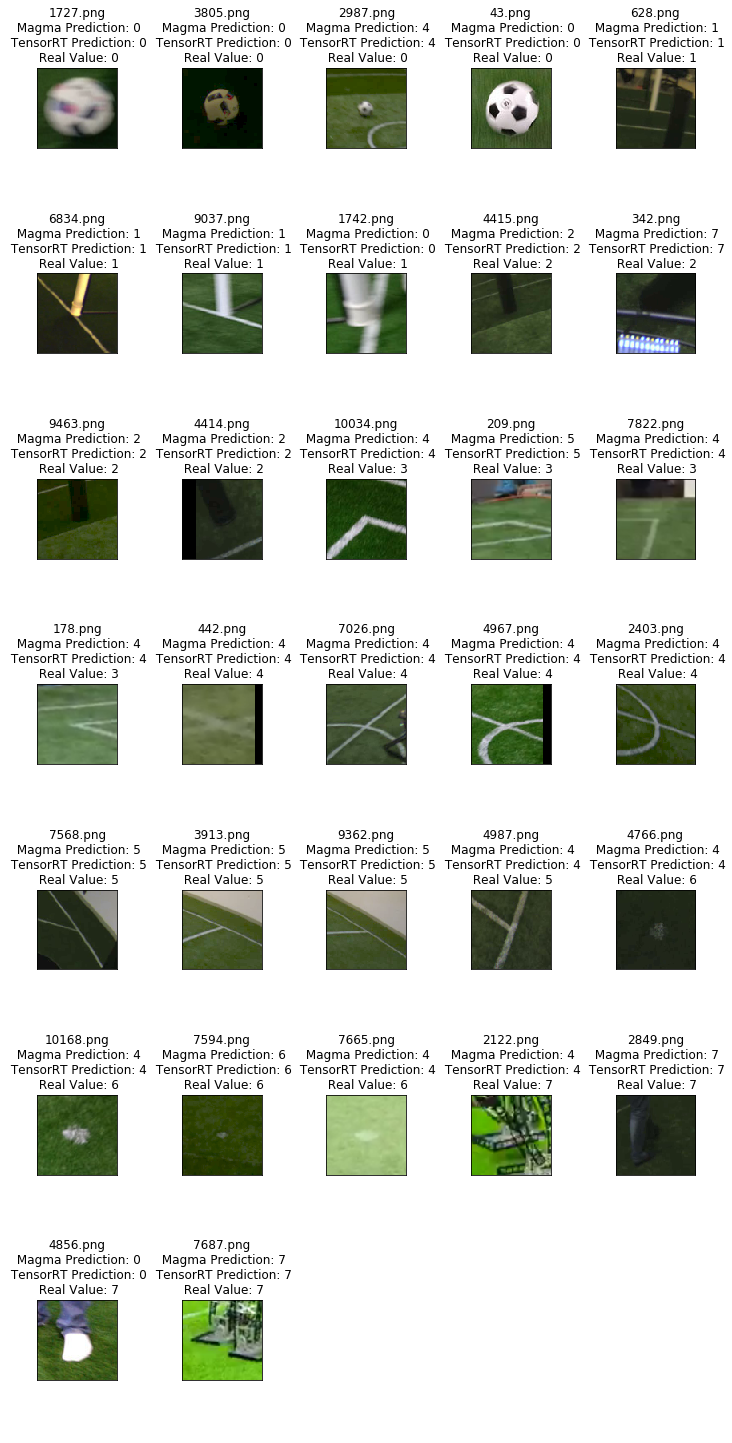

In [36]:
COLS = 5
rows = len(images)//COLS+1
print('COLS {}, rows {}'.format(COLS,rows))
fig, axes =  plt.subplots(nrows=rows, ncols=COLS, figsize=(10,20), constrained_layout=True)

# delete unused axes
for i in range( -(rows*COLS-len(images)),0):
    fig.delaxes(axes[rows-1,i])  

for idx, image in enumerate(images):
    col = idx%COLS
    row = idx//COLS
    
    img = load_img(path=image[0], color_mode='rgb', target_size=DATA_SHAPE)
    img = np.squeeze(img)
    axes[row,col].imshow(img,aspect='equal')
    axes[row,col].set_title('{}\n Magma Prediction: {}\n TensorRT Prediction: {}\n Real Value: {}'.format(
                        image[2], np.argmax(magma_pred[idx]),np.argmax(trt_pred[idx]), image[1]),fontsize=12)
    axes[row,col].tick_params(bottom=False, left=False,  labelleft=False, labelbottom=False)